<a href="https://colab.research.google.com/github/Enhua1001/github-actions/blob/main/4_2_Linear_Modelling_Part_3__adding_feat__wardcode%2C_inciStat_and_DelayCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Modelling Part 3 -- Adding features IncGeoWardCodes, IncidentStationGround and DelayCodeDescription**

# **Notebook Overview**

The orginal problem of the project is a regression problem (to predict the continous target variable TravelTimeSconds). We try to also transform the problem into a classification problem by binning the TravelTimeSeconds into 4 classes (TravelTimeClass).

This notebook performs linear modellings with two alternatives in order to achieve the project goal:


*   Using RidgeClassifierCV to predict the TravelTimeClass (Classficiation)
*   Using RidgeCV to predict the TravelTimeSeconds (Regression)

The linear models are trained and evaluated on sub-datasets containing 1-year, 5-year and 10-year data respectively.

Additinal Features being used for the modellings in this notebook are IncGeoWardCodes, IncidentStationGround and DelayCodeDescription on top of the pre-selected features in part 1.

# **1. Import Libraries**

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, KBinsDiscretizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, XGBRegressor
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# **2. Explore Basic DataFrame**

## **2.1 Check df8**

In [ ]:
# Import the basic DataFrame df8
df = pd.read_pickle('/Users/enhuali/Documents_Enhua/Data Science Notes/Python/df8.pkl')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
# Check shape
df.shape

(2135801, 96)

In [ ]:
# Check columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2135801 entries, 127 to 2150338
Data columns (total 96 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   IncidentNumber                             object        
 1   DateOfCall                                 datetime64[ns]
 2   CalYear                                    int64         
 3   TimeOfCall                                 object        
 4   HourOfCall                                 int64         
 5   IncidentGroup                              object        
 6   StopCodeDescription                        object        
 7   SpecialServiceType                         object        
 8   PropertyCategory                           object        
 9   PropertyType                               object        
 10  AddressQualifier                           object        
 11  Postcode_full                              object        
 12  Pos

In [ ]:
# Check if there is any duplicated rows

df.duplicated().sum()

0

In [ ]:
# Change the proj_TravelTime columns to data type float64

proj_TraveTime = ['proj_TravelTimeSeconds_previous_1', 'proj_TravelTimeSeconds_previous_2', 'proj_TravelTimeSeconds_previous_3', 'proj_TravelTimeSeconds_previous_4',
                  'proj_TravelTimeSeconds_previous_5']

df[proj_TraveTime] = df[proj_TraveTime].astype('float64')

In [ ]:
# Check columns again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2135801 entries, 127 to 2150338
Data columns (total 96 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   IncidentNumber                             object        
 1   DateOfCall                                 datetime64[ns]
 2   CalYear                                    int64         
 3   TimeOfCall                                 object        
 4   HourOfCall                                 int64         
 5   IncidentGroup                              object        
 6   StopCodeDescription                        object        
 7   SpecialServiceType                         object        
 8   PropertyCategory                           object        
 9   PropertyType                               object        
 10  AddressQualifier                           object        
 11  Postcode_full                              object        
 12  Pos

## **2.2 Columns to keep before feature selection**

In [ ]:
# Excluding variables that obviously will not contribute to predicting target variable TravelTime or are duplicates of other columns
# Not using EstimatedDistanceKMs as the columns are calculated by using target variable TraveTimeSeconds and thus can't be used as explanatory variable to "predict" Travel Time again.

# Numeric variables that should be scaled using MinMaxScaler
num_var1 = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'NumCalls', 'proj_Snowfall', 'proj_WindForce', 'proj_PastIncidentsCount']

# Numeric variables that should be scaled using StandardScaler
num_var2 = ['proj_Air_Distance_rounded', 'proj_MinimumTemperature', 'proj_MaximumTemperature', 'proj_Precipitation', 'proj_WindSpeed', 'proj_TravelTimeSeconds_previous_1',
            'proj_TravelTimeSeconds_previous_2', 'proj_TravelTimeSeconds_previous_3', 'proj_TravelTimeSeconds_previous_4', 'proj_TravelTimeSeconds_previous_5']

# Categorical variables
cat_var = ['CalYear' ,'HourOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
            'IncGeo_BoroughCode', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Description', 'proj_CalMonth',
            'proj_CalWeekday', 'proj_CityCenter', 'proj_PeakHours', 'proj_WindDescription', 'DelayCode_Description', 'IncidentStationGround', 'IncGeo_WardCode']


# Target variable TravelTimeSeconds

In [ ]:
# Keep only the columns as defined above

df = df[num_var1 + num_var2 + cat_var + ['TravelTimeSeconds']]
df = pd.DataFrame(df)


In [ ]:
# Check the columns of df

print(df.columns)

Index(['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'NumCalls', 'proj_Snowfall', 'proj_WindForce',
       'proj_PastIncidentsCount', 'proj_Air_Distance_rounded',
       'proj_MinimumTemperature', 'proj_MaximumTemperature',
       'proj_Precipitation', 'proj_WindSpeed',
       'proj_TravelTimeSeconds_previous_1',
       'proj_TravelTimeSeconds_previous_2',
       'proj_TravelTimeSeconds_previous_3',
       'proj_TravelTimeSeconds_previous_4',
       'proj_TravelTimeSeconds_previous_5', 'CalYear', 'HourOfCall',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier',
       'IncGeo_BoroughCode', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PumpOrder', 'PlusCode_Description',
       'proj_CalMonth', 'proj_CalWeekday', 'proj_CityCenter', 'proj_PeakHours',
       'proj_WindDescription', 'DelayCode_Description',
       'IncidentStationGround', 'IncGeo_WardCode', 'TravelTimeS

In [ ]:
# Change some of the column names (deleting the "-" in the name, so that it is more easy to get important feature list in next steps)

rename = {'proj_Snowfall': 'projSnowfall', 'proj_WindForce': 'projWindForce', 'proj_PastIncidentsCount': 'projPastIncidentsCount','proj_Air_Distance_rounded': 'projAirDistanceRounded',
          'proj_MinimumTemperature': 'projMinTemp', 'proj_MaximumTemperature': 'projMaxTemp', 'proj_Precipitation': 'projPrecipitation', 'proj_WindSpeed': 'projWindSpeed',
          'proj_TravelTimeSeconds_previous_1': 'projTravelTimesSecondsPrevious1', 'proj_TravelTimeSeconds_previous_2': 'projTravelTimesSecondsPrevious2',
          'proj_TravelTimeSeconds_previous_3': 'projTravelTimesSecondsPrevious3', 'proj_TravelTimeSeconds_previous_4': 'projTravelTimesSecondsPrevious4',
          'proj_TravelTimeSeconds_previous_5': 'projTravelTimesSecondsPrevious5',
          'IncGeo_BoroughCode': 'IncGeoBoroughCode', 'DeployedFromStation_Name': 'DeployedFromStationName',
          'PlusCode_Description': 'PlusCodeDescription', 'proj_CalMonth': 'projCalMonth', 'proj_CalWeekday': 'projCalWeekday', 'proj_CityCenter': 'projCityCenter', 'proj_PeakHours': 'projPeakHours',
          'proj_WindDescription': 'projWindDescription', 'DelayCode_Description': 'DelayCodeDescription', 'IncGeo_WardCode': 'IncGeoWardCode'}

In [ ]:
# Renaming

df = df.rename(columns=rename)

In [ ]:
# Check column headers

print(df.columns)

Index(['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'NumCalls', 'projSnowfall', 'projWindForce', 'projPastIncidentsCount',
       'projAirDistanceRounded', 'projMinTemp', 'projMaxTemp',
       'projPrecipitation', 'projWindSpeed', 'projTravelTimesSecondsPrevious1',
       'projTravelTimesSecondsPrevious2', 'projTravelTimesSecondsPrevious3',
       'projTravelTimesSecondsPrevious4', 'projTravelTimesSecondsPrevious5',
       'CalYear', 'HourOfCall', 'IncidentGroup', 'StopCodeDescription',
       'SpecialServiceType', 'PropertyCategory', 'PropertyType',
       'AddressQualifier', 'IncGeoBoroughCode', 'DeployedFromStationName',
       'DeployedFromLocation', 'PumpOrder', 'PlusCodeDescription',
       'projCalMonth', 'projCalWeekday', 'projCityCenter', 'projPeakHours',
       'projWindDescription', 'DelayCodeDescription', 'IncidentStationGround',
       'IncGeoWardCode', 'TravelTimeSeconds'],
      dtype='object')


In [ ]:
# Check shape
df.shape

(2135801, 39)

In [ ]:
# Check missing values

df_missing = df.isnull().sum() / len(df) * 100

print(df_missing[df_missing > 0])

projWindForce                       0.047242
projMinTemp                         0.018775
projMaxTemp                         0.029825
projWindSpeed                       0.047242
projTravelTimesSecondsPrevious1     0.006649
projTravelTimesSecondsPrevious2     0.013297
projTravelTimesSecondsPrevious3     0.019946
projTravelTimesSecondsPrevious4     0.026594
projTravelTimesSecondsPrevious5     0.033243
SpecialServiceType                 78.612052
projWindDescription                 0.047242
DelayCodeDescription               74.876686
dtype: float64


In [ ]:
# Except SpecialServiceType, we drop the rows containing missing values
# First, fill in missing values for SpecialServiceType with value 'unknow'

df['SpecialServiceType'] = df['SpecialServiceType'].fillna('Unknown')
df['DelayCodeDescription'] = df['DelayCodeDescription'].fillna('Unknown')


In [ ]:
# check
df_missing = df.isnull().sum() / len(df) * 100

print(df_missing[df_missing > 0])

projWindForce                      0.047242
projMinTemp                        0.018775
projMaxTemp                        0.029825
projWindSpeed                      0.047242
projTravelTimesSecondsPrevious1    0.006649
projTravelTimesSecondsPrevious2    0.013297
projTravelTimesSecondsPrevious3    0.019946
projTravelTimesSecondsPrevious4    0.026594
projTravelTimesSecondsPrevious5    0.033243
projWindDescription                0.047242
dtype: float64


In [ ]:
# Drop missing values

df = df.dropna()

In [ ]:
# Check missing values again
df_missing = df.isnull().sum() / len(df) * 100

print(df_missing[df_missing > 0])

Series([], dtype: float64)


In [ ]:
# Check duplicates

df.duplicated().sum()

0

In [ ]:
# Check shape
df.shape

(2134082, 39)

## **2.4 Create binned Target variable**

In [ ]:
# Check the statistics of TravelTimeSeconds

df.TravelTimeSeconds.describe()

count    2.134082e+06
mean     2.762390e+02
std      1.503876e+02
min      0.000000e+00
25%      1.760000e+02
50%      2.500000e+02
75%      3.450000e+02
max      1.195000e+03
Name: TravelTimeSeconds, dtype: float64

In [ ]:
# Create discrete Target variable

k_bins = 4
discretizer = KBinsDiscretizer(n_bins=k_bins, encode='ordinal', strategy='quantile')
df['TravelTimeClass'] = discretizer.fit_transform(df[['TravelTimeSeconds']])

# Convert numeric bins to labels
df['TravelTimeClass'] = df['TravelTimeClass'].apply(lambda x: f'Bin{x+1}')

# Summary of bin counts
bin_counts = df.TravelTimeClass.value_counts()
print(bin_counts)

TravelTimeClass
Bin4.0    535713
Bin3.0    534006
Bin1.0    532885
Bin2.0    531478
Name: count, dtype: int64


In [ ]:
# Display bin edges

bin_edges = discretizer.bin_edges_[0]
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {bin_edges[i]} seconds to {bin_edges[i+1]} seconds")

Bin 1: 0.0 seconds to 176.0 seconds
Bin 2: 176.0 seconds to 250.0 seconds
Bin 3: 250.0 seconds to 345.0 seconds
Bin 4: 345.0 seconds to 1193.0 seconds


In [ ]:
# Check

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2134082 entries, 127 to 2150333
Data columns (total 40 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   NumStationsWithPumpsAttending    float64
 1   NumPumpsAttending                float64
 2   PumpCount                        int64  
 3   NumCalls                         float64
 4   projSnowfall                     float64
 5   projWindForce                    float64
 6   projPastIncidentsCount           int64  
 7   projAirDistanceRounded           float64
 8   projMinTemp                      float64
 9   projMaxTemp                      float64
 10  projPrecipitation                float64
 11  projWindSpeed                    float64
 12  projTravelTimesSecondsPrevious1  float64
 13  projTravelTimesSecondsPrevious2  float64
 14  projTravelTimesSecondsPrevious3  float64
 15  projTravelTimesSecondsPrevious4  float64
 16  projTravelTimesSecondsPrevious5  float64
 17  CalYear    

# **3. Take 1 Year Data**

## **3.1. Take CalYear 2023**

In [ ]:
# Take only CalYear 2023

df_1 = df[df.CalYear == 2023]
df_1 = pd.DataFrame(df_1)

In [ ]:
# Check the CalYear in df_1
df_1.CalYear.unique()

array([2023])

In [ ]:

 # Drop column CalYear
df_1 = df_1.drop('CalYear', axis=1)

In [ ]:
# Check duplicates
df_1.duplicated().sum()

0

## **3.2. Discrete Target Variable**

### **3.2.1. Pre-Processing data**

In [ ]:
# Create datasets for features and target

X = df_1.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y = df_1.TravelTimeClass

In [ ]:
# Numeric variables that should be scaled using MinMaxScaler
num_var1 = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'NumCalls', 'projSnowfall', 'projWindForce', 'projPastIncidentsCount']

# Numeric variables that should be scaled using StandardScaler
num_var2 = ['projAirDistanceRounded', 'projMinTemp', 'projMaxTemp', 'projPrecipitation', 'projWindSpeed', 'projTravelTimesSecondsPrevious1',
       'projTravelTimesSecondsPrevious2', 'projTravelTimesSecondsPrevious3',
       'projTravelTimesSecondsPrevious4', 'projTravelTimesSecondsPrevious5']

# Categorical variables

cat_var = ['HourOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
            'IncGeoBoroughCode', 'DeployedFromStationName', 'DeployedFromLocation', 'PumpOrder', 'PlusCodeDescription', 'projCalMonth',
            'projCalWeekday', 'projCityCenter', 'projPeakHours', 'projWindDescription', 'DelayCodeDescription', 'IncidentStationGround', 'IncGeoWardCode']

In [ ]:
# Define the preprocessor pipeline

preprocessor = ColumnTransformer(transformers=[('num1', MinMaxScaler(), num_var1), ('num2', StandardScaler(), num_var2), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)])

In [ ]:
# Split the train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# Transform the train and test datasets

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Check the shape of transformed train and test datasets

print(X_train_transformed.shape, X_test_transformed.shape)

(147512, 1362) (36879, 1362)


In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=all_feature_names)
X_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=all_feature_names)

In [ ]:
# Check shape
print(X_train_transformed_df.shape, X_test_transformed_df.shape)

(147512, 1362) (36879, 1362)


### **3.2.2 RidgeClassifierCV**

#### **3.2.2.1. Train the model and assess model performance**

In [ ]:
# Train the model

rdc_cv = RidgeClassifierCV()

rdc_cv.fit(X_train_transformed_df, y_train)

RidgeClassifierCV()

In [ ]:
# Get the best alpha

rdc_cv.alpha_

10.0

In [ ]:
# Make predictions
y_pred_train_rdccv = rdc_cv.predict(X_train_transformed_df)
y_pred_test_rdccv = rdc_cv.predict(X_test_transformed_df)

In [ ]:
# Assess the performance

class_report_train_rdccv = classification_report(y_train, y_pred_train_rdccv)
class_report_test_rdccv = classification_report(y_test, y_pred_test_rdccv)

print('Classification report on train data: \n', class_report_train_rdccv)
print()
print('Classification report on test data: \n', class_report_test_rdccv)

Classification report on train data: 
               precision    recall  f1-score   support

      Bin1.0       0.59      0.65      0.62     32547
      Bin2.0       0.49      0.56      0.53     35397
      Bin3.0       0.53      0.21      0.30     37992
      Bin4.0       0.66      0.90      0.76     41576

    accuracy                           0.59    147512
   macro avg       0.57      0.58      0.55    147512
weighted avg       0.57      0.59      0.55    147512


Classification report on test data: 
               precision    recall  f1-score   support

      Bin1.0       0.57      0.63      0.60      8087
      Bin2.0       0.47      0.55      0.51      8864
      Bin3.0       0.51      0.19      0.28      9692
      Bin4.0       0.66      0.90      0.76     10236

    accuracy                           0.57     36879
   macro avg       0.55      0.57      0.54     36879
weighted avg       0.55      0.57      0.54     36879



#### **3.2.2.2. Feature Importance by SHAP Analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdc_cv, X_train_transformed_df)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


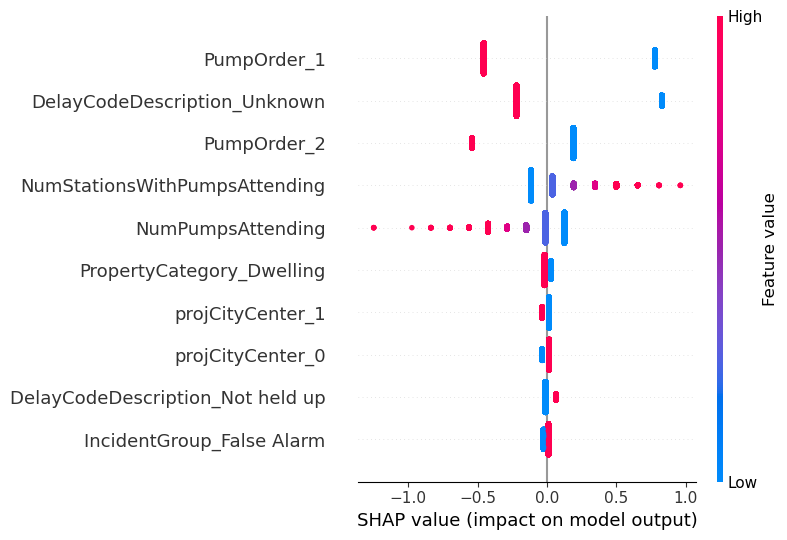

In [ ]:
# Check the feature (encoded) importance for a certain target class, example for class 3

shap_values_class = explainer(X_test_transformed_df)

shap.summary_plot(shap_values_class[:,:,3], X_test_transformed_df, max_display=10)


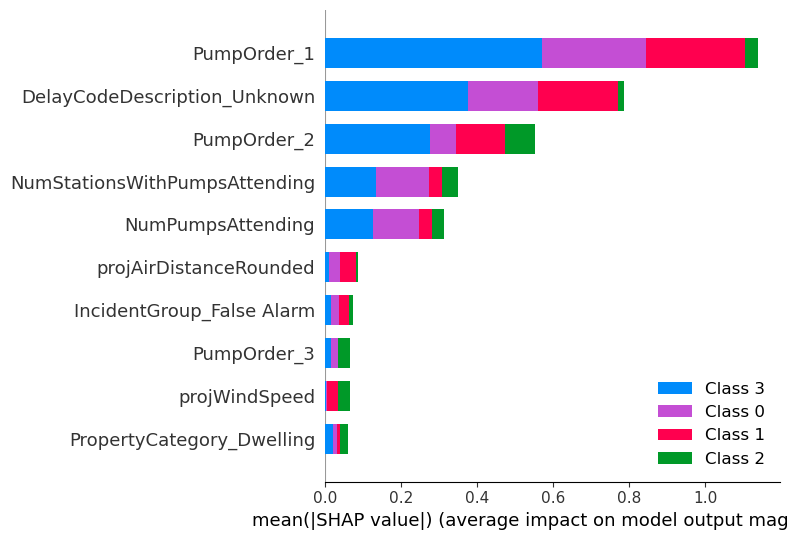

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X_test_transformed_df)

shap.summary_plot(shap_values, X_test_transformed_df, max_display=10, color_bar=True)

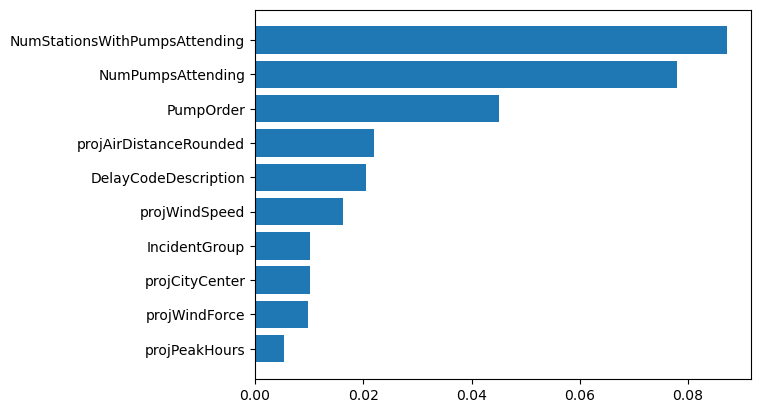

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.mean(np.abs(shap_values), axis=0), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

## **3.3. Continous Target Variable**

### **3.3.1 Data Pre-Processing**

In [ ]:
# Create datasets for features and target

X2 = df_1.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y2 = df_1.TravelTimeSeconds

In [ ]:
# Split the train and test datasets

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [ ]:
# Fit and transform the train and test datasets

X2_train_transformed = preprocessor.fit_transform(X2_train)
X2_test_transformed = preprocessor.transform(X2_test)

In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X2_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_train_transformed, columns=all_feature_names)
X2_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_test_transformed, columns=all_feature_names)

In [ ]:
# Check shape
print(X2_train_transformed_df.shape, X2_test_transformed_df.shape)

(147512, 1362) (36879, 1362)


### **3.3.2. RidgeCV**

#### **3.3.2.1 Train and assess the model performance**

In [ ]:
# Train the model

rdg_cv = RidgeCV()

rdg_cv.fit(X2_train_transformed_df, y2_train)

RidgeCV()

In [ ]:
# Get the best alpha

rdg_cv.alpha_

10.0

In [ ]:
# Make predictions

y2_pred_train_rdgcv = rdg_cv.predict(X2_train_transformed_df)
y2_pred_test_rdgcv = rdg_cv.predict(X2_test_transformed_df)

In [ ]:
# Assess the model performance

print('Score on train data:', rdg_cv.score(X2_train_transformed_df, y2_train))
print('Score on test data:', rdg_cv.score(X2_test_transformed_df, y2_test))
print()
print('mse on train data: ', mean_squared_error(y2_pred_train_rdgcv, y2_train))
print('mse on test data: ', mean_squared_error(y2_pred_test_rdgcv, y2_test))

Score on train data: 0.6084287668818413
Score on test data: 0.598662085619439

mse on train data:  8737.24601573961
mse on test data:  9002.167406281653


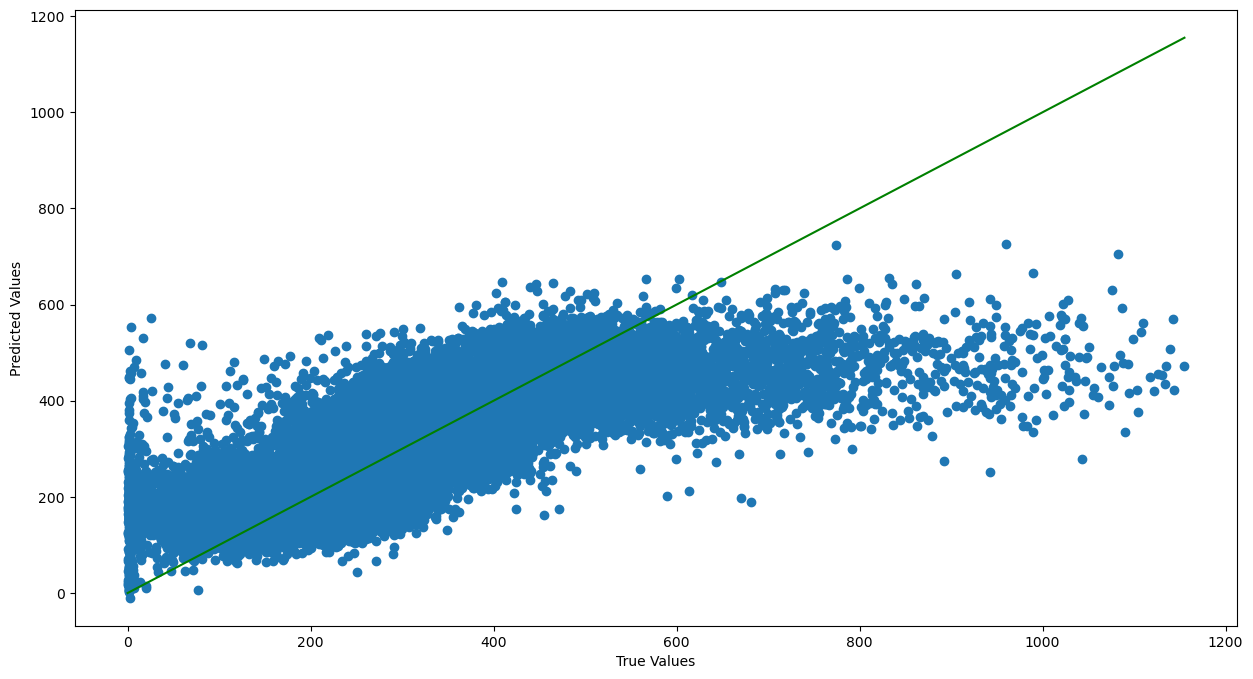

In [ ]:
# Heteroskedasticity plot


plt.figure(figsize=(15,8))
plt.scatter(y2_test, y2_pred_test_rdgcv)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], color='green')


plt.show()

#### **3.3.2.2. Feature Importance by SHAP analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdg_cv, X2_train_transformed_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


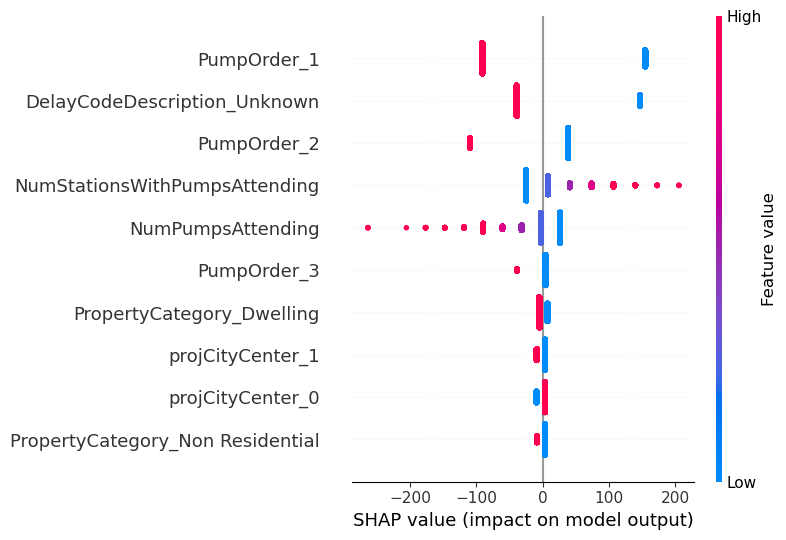

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X2_test_transformed_df)

shap.summary_plot(shap_values, X2_test_transformed_df, max_display=10, color_bar=True)

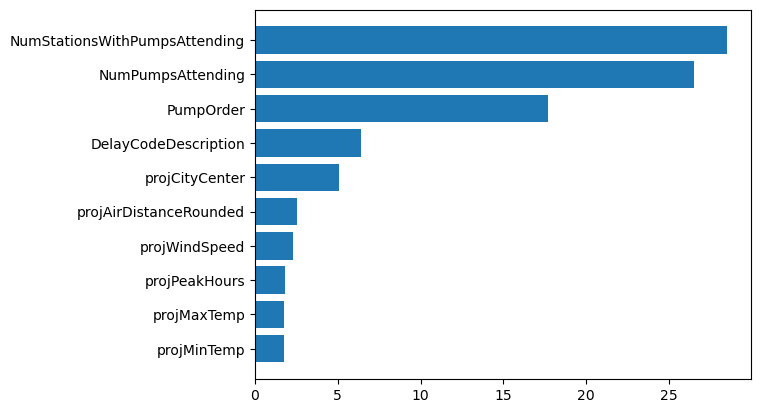

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.abs(shap_values), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

# **4. Take 5 Year Data**

## **4.1. Take CalYear 2019 - 2024**

In [ ]:
# Take CalYear 2019 to 2024

df_5 = df[df.CalYear.isin([2019, 2020, 2021, 2022, 2023, 2024])]
df_5 = pd.DataFrame(df_5)

In [ ]:
# Check the CalYear in df_5
df_5.CalYear.unique()

array([2024, 2023, 2022, 2021, 2020, 2019])

In [ ]:
# Drop the Column CalYear

df_5 = df_5.drop('CalYear', axis=1)

In [ ]:
# Check duplicates

df_5.duplicated().sum()

0

## **4.2 Discrete Target Variable**

### **4.2.1. Pro-processing the data**

In [ ]:
# Create datasets for features and target

X = df_5.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y = df_5.TravelTimeClass

In [ ]:
# Numeric variables that should be scaled using MinMaxScaler
num_var1 = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'NumCalls', 'projSnowfall', 'projWindForce', 'projPastIncidentsCount']

# Numeric variables that should be scaled using StandardScaler
num_var2 = ['projAirDistanceRounded', 'projMinTemp', 'projMaxTemp', 'projPrecipitation', 'projWindSpeed', 'projTravelTimesSecondsPrevious1',
       'projTravelTimesSecondsPrevious2', 'projTravelTimesSecondsPrevious3',
       'projTravelTimesSecondsPrevious4', 'projTravelTimesSecondsPrevious5']

# Categorical variables

cat_var = ['HourOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
            'IncGeoBoroughCode', 'DeployedFromStationName', 'DeployedFromLocation', 'PumpOrder', 'PlusCodeDescription', 'projCalMonth',
            'projCalWeekday', 'projCityCenter', 'projPeakHours', 'projWindDescription', 'DelayCodeDescription', 'IncidentStationGround', 'IncGeoWardCode']

In [ ]:
# Define the preprocessor pipeline

preprocessor = ColumnTransformer(transformers=[('num1', MinMaxScaler(), num_var1), ('num2', StandardScaler(), num_var2), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)])

In [ ]:
# Split the train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# Transform the train and test datasets

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Check the shape

print(X_train_transformed.shape, X_test_transformed.shape)

(695400, 1426) (173851, 1426)


In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=all_feature_names)
X_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=all_feature_names)

In [ ]:
# Check the shapes

print(X_train_transformed_df.shape, X_test_transformed_df.shape)

(695400, 1426) (173851, 1426)


### **4.2.2 RidgeClassifierCV**

#### **4.2.2.1. Train the model and assess model peformance**

In [ ]:
# Train the model

rdc_cv = RidgeClassifierCV()

rdc_cv.fit(X_train_transformed_df, y_train)

RidgeClassifierCV()

In [ ]:
# Get the best alpha

rdc_cv.alpha_

10.0

In [ ]:
# Make predictions

y_pred_train_rdccv = rdc_cv.predict(X_train_transformed_df)
y_pred_test_rdccv = rdc_cv.predict(X_test_transformed_df)

In [ ]:
# Assess the performance

class_report_train_rdccv = classification_report(y_train, y_pred_train_rdccv)
class_report_test_rdccv = classification_report(y_test, y_pred_test_rdccv)

print('Classification report on train data: \n', class_report_train_rdccv)
print()
print('Classification report on test data: \n', class_report_test_rdccv)

Classification report on train data: 
               precision    recall  f1-score   support

      Bin1.0       0.58      0.66      0.62    161388
      Bin2.0       0.48      0.55      0.52    173921
      Bin3.0       0.52      0.20      0.29    180956
      Bin4.0       0.65      0.88      0.75    179135

    accuracy                           0.57    695400
   macro avg       0.56      0.57      0.54    695400
weighted avg       0.56      0.57      0.54    695400


Classification report on test data: 
               precision    recall  f1-score   support

      Bin1.0       0.57      0.65      0.61     40080
      Bin2.0       0.48      0.54      0.51     43560
      Bin3.0       0.51      0.20      0.29     45214
      Bin4.0       0.65      0.88      0.74     44997

    accuracy                           0.57    173851
   macro avg       0.55      0.57      0.54    173851
weighted avg       0.55      0.57      0.54    173851



#### **4.2.2.2 Feature Importance by SHAP Analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdc_cv, X_train_transformed_df)

Linear explainer: 173852it [00:11, 1062.79it/s]                             
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


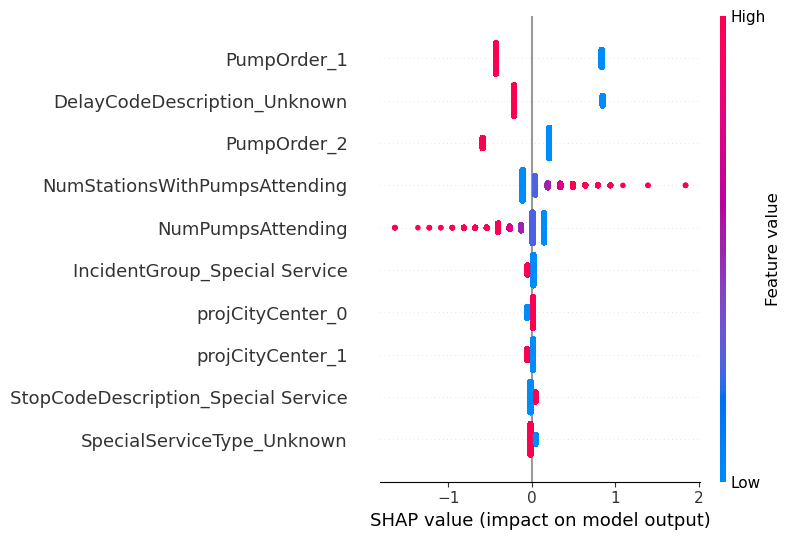

In [ ]:
# Check the feature (encoded) importance for a certain target class, example for class 3

shap_values_class = explainer(X_test_transformed_df)

shap.summary_plot(shap_values_class[:,:,3], X_test_transformed_df, max_display=10)

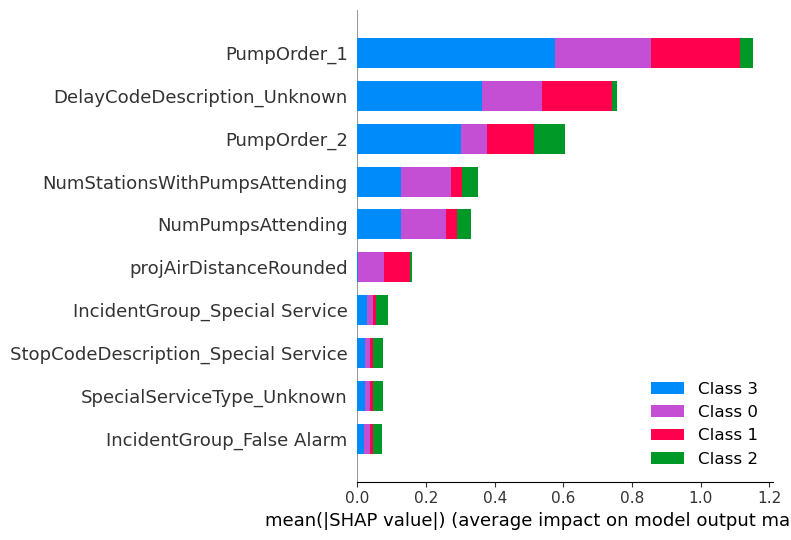

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X_test_transformed_df)

shap.summary_plot(shap_values, X_test_transformed_df, max_display=10, color_bar=True)

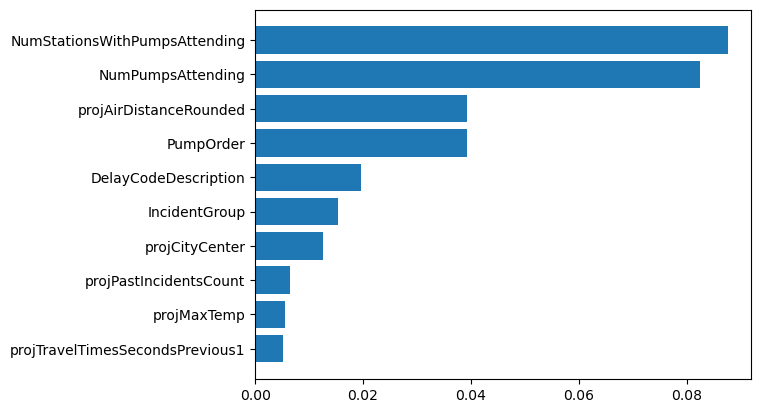

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.mean(np.abs(shap_values), axis=0), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

## **4.3. Continuous Target Variable**

#### **4.3.1. Data Pre-processing**

In [ ]:
# Create datasets for features and target

X2 = df_5.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y2 = df_5.TravelTimeSeconds

In [ ]:
# Spilt the train and test datasets

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [ ]:
# Fit and transform the train and test datasets

X2_train_transformed = preprocessor.fit_transform(X2_train)
X2_test_transformed = preprocessor.transform(X2_test)

In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X2_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_train_transformed, columns=all_feature_names)
X2_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_test_transformed, columns=all_feature_names)

In [ ]:
# Check shape

print(X2_train_transformed_df.shape, X2_test_transformed_df.shape)

(695400, 1426) (173851, 1426)


### **4.3.2. RidgeCV**

#### **4.3.2.1. Train and assess the model performance**

In [ ]:
# Train the model

rdg_cv = RidgeCV()

rdg_cv.fit(X2_train_transformed_df, y2_train)

RidgeCV()

In [ ]:
# Get the best alpha

rdg_cv.alpha_

10.0

In [ ]:
# Make predictions

y2_pred_train_rdgcv = rdg_cv.predict(X2_train_transformed_df)
y2_pred_test_rdgcv = rdg_cv.predict(X2_test_transformed_df)

In [ ]:
# Assess the model performance

print('Score on train data: ', rdg_cv.score(X2_train_transformed_df, y2_train))
print('Score on test data: ', rdg_cv.score(X2_test_transformed_df, y2_test))
print()
print('mse on train data: ', mean_squared_error(y2_pred_train_rdgcv, y2_train))
print('mse on test data: ', mean_squared_error(y2_pred_test_rdgcv, y2_test))

Score on train data:  0.5948358867357824
Score on test data:  0.5935739645533545

mse on train data:  8712.896301949744
mse on test data:  8739.065185574962


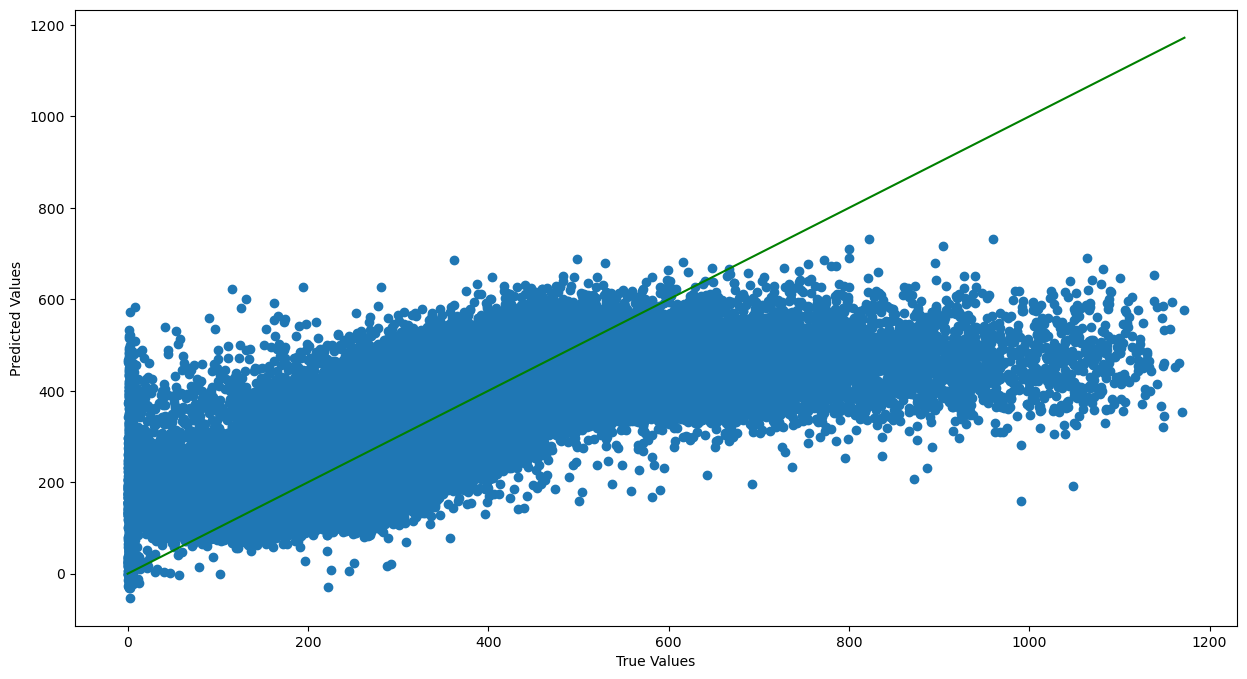

In [ ]:
# Heteroskedasticity plot


plt.figure(figsize=(15,8))
plt.scatter(y2_test, y2_pred_test_rdgcv)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], color='green')


plt.show()

#### **4.3.2.2. Feature Importance by SHAP Analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdg_cv, X2_train_transformed_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


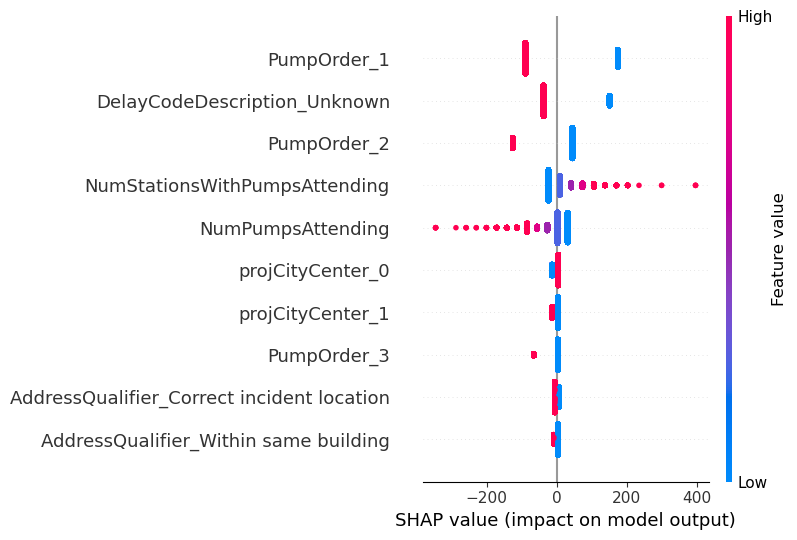

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X2_test_transformed_df)

shap.summary_plot(shap_values, X2_test_transformed_df, max_display=10, color_bar=True)

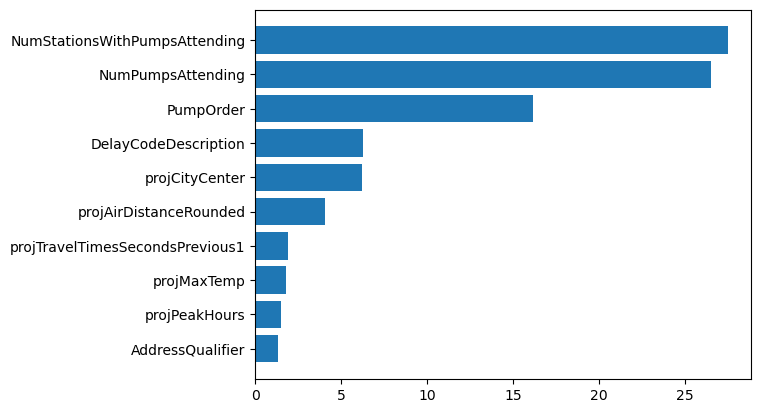

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.abs(shap_values), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

# **5. Take 10 Year Data**

## **5.1. Take CalYaar 2014 to 2024**

In [ ]:
# Take CalYear 2014 to 2024

df_10 = df[df.CalYear.isin([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])]
df_10 = pd.DataFrame(df_10)

In [ ]:
# Check the CalYear in df_10
df_10.CalYear.unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014])

In [ ]:
# Drop the column CalYear

df_10 = df_10.drop('CalYear', axis=1)

In [ ]:
# Check duplicates

df_10.duplicated().sum()

0

## **5.2. Discrete Target Variable**

### **5.2.1. Data Pre-Processing**

In [ ]:
# Create datasets for features and target

X = df_10.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y = df_10.TravelTimeClass

In [ ]:
# Numeric variables that should be scaled using MinMaxScaler
num_var1 = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'NumCalls', 'projSnowfall', 'projWindForce', 'projPastIncidentsCount']

# Numeric variables that should be scaled using StandardScaler
num_var2 = ['projAirDistanceRounded', 'projMinTemp', 'projMaxTemp', 'projPrecipitation', 'projWindSpeed', 'projTravelTimesSecondsPrevious1',
       'projTravelTimesSecondsPrevious2', 'projTravelTimesSecondsPrevious3',
       'projTravelTimesSecondsPrevious4', 'projTravelTimesSecondsPrevious5']

# Categorical variables

cat_var = ['HourOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
            'IncGeoBoroughCode', 'DeployedFromStationName', 'DeployedFromLocation', 'PumpOrder', 'PlusCodeDescription', 'projCalMonth',
            'projCalWeekday', 'projCityCenter', 'projPeakHours', 'projWindDescription', 'DelayCodeDescription', 'IncidentStationGround', 'IncGeoWardCode']

In [ ]:
# Define the preprocessor pipeline

preprocessor = ColumnTransformer(transformers=[('num1', MinMaxScaler(), num_var1), ('num2', StandardScaler(), num_var2), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)])

In [ ]:
# Split the train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# Transform the train and test datasets

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=all_feature_names)
X_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=all_feature_names)

In [ ]:
# Check shape

print(X_train_transformed_df.shape, X_test_transformed_df.shape)

(1250246, 1563) (312562, 1563)


### **5.2.2. RidgeClassifierCV**

#### **5.2.2.1. Train and Assess model performance**

In [ ]:
# Train the model

rdc_cv = RidgeClassifierCV()

rdc_cv.fit(X_train_transformed_df, y_train)

RidgeClassifierCV()

In [ ]:
# Get the best alpha

rdc_cv.alpha_

10.0

In [ ]:
# Make predictions

y_pred_train_rdccv = rdc_cv.predict(X_train_transformed_df)
y_pred_test_rdccv = rdc_cv.predict(X_test_transformed_df)

In [ ]:
class_report_train_rdccv = classification_report(y_train, y_pred_train_rdccv)
class_report_test_rdccv = classification_report(y_test, y_pred_test_rdccv)

print('Classification report on train data: \n', class_report_train_rdccv)
print()
print('Classification report on test data: \n', class_report_test_rdccv)

Classification report on train data: 
               precision    recall  f1-score   support

      Bin1.0       0.57      0.65      0.61    288526
      Bin2.0       0.48      0.56      0.52    314597
      Bin3.0       0.52      0.19      0.28    324242
      Bin4.0       0.65      0.88      0.75    322881

    accuracy                           0.57   1250246
   macro avg       0.55      0.57      0.54   1250246
weighted avg       0.55      0.57      0.54   1250246


Classification report on test data: 
               precision    recall  f1-score   support

      Bin1.0       0.57      0.65      0.61     72125
      Bin2.0       0.47      0.56      0.51     78487
      Bin3.0       0.51      0.19      0.27     80984
      Bin4.0       0.65      0.88      0.75     80966

    accuracy                           0.57    312562
   macro avg       0.55      0.57      0.54    312562
weighted avg       0.55      0.57      0.53    312562



#### **5.2.2.2. Feature Importance by SHAP Analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdc_cv, X_train_transformed_df)

Linear explainer: 312563it [00:24, 6915.08it/s]                             
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


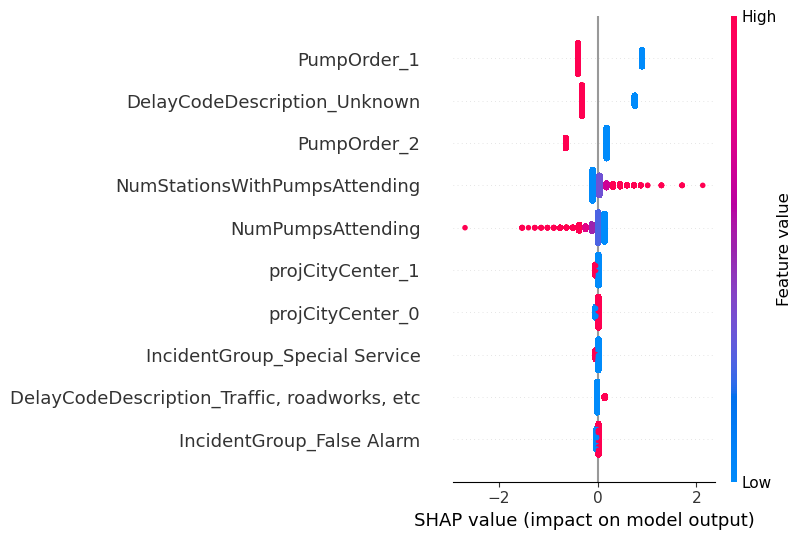

In [ ]:
# Check the feature (encoded) importance for a certain target class, example for class 3

shap_values_class = explainer(X_test_transformed_df)

shap.summary_plot(shap_values_class[:,:,3], X_test_transformed_df, max_display=10)

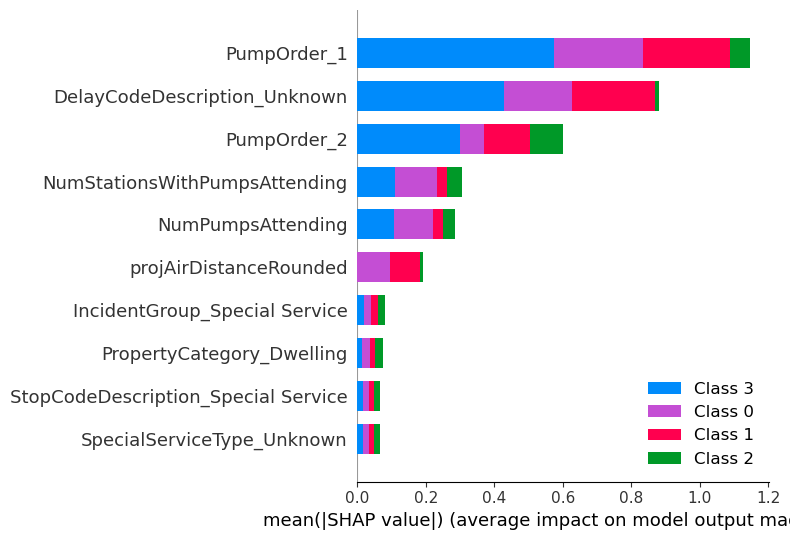

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X_test_transformed_df)

shap.summary_plot(shap_values, X_test_transformed_df, max_display=10, color_bar=True)

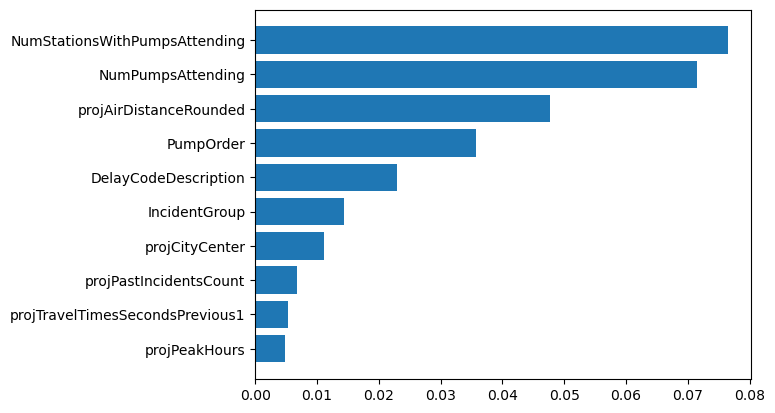

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.mean(np.abs(shap_values), axis=0), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

## **5.3. Continuous Target Variable**

### **5.3.1. Data Pre-processing**

In [ ]:
# Create datasets for feature and target

X2 = df_10.drop(['TravelTimeSeconds', 'TravelTimeClass'], axis=1)
y2 = df_10.TravelTimeSeconds

In [ ]:
# Split the train and test datasets

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [ ]:
# Fit and transform the train and test datasets

X2_train_transformed = preprocessor.fit_transform(X2_train)
X2_test_transformed = preprocessor.transform(X2_test)

In [ ]:
# Transform the train and test datasets into DataFrames with feature labels

one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names_transformed = one_hot_encoder.get_feature_names_out(cat_var).tolist()
numeric_feature_names = num_var1 + num_var2

all_feature_names = numeric_feature_names + one_hot_feature_names_transformed

X2_train_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_train_transformed, columns=all_feature_names)
X2_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X2_test_transformed, columns=all_feature_names)

In [ ]:
# Check shape

print(X2_train_transformed_df.shape, X2_test_transformed_df.shape)

(1250246, 1563) (312562, 1563)


### **5.3.2. RidgeCV**

#### **5.3.2.1. Train and Assess model performance**

In [ ]:
# Train the model

rdg_cv = RidgeCV()

rdg_cv.fit(X2_train_transformed_df, y2_train)

RidgeCV()

In [ ]:
# Get the best alpha

rdg_cv.alpha_

10.0

In [ ]:
# Make predictions

y2_pred_train_rdgcv = rdg_cv.predict(X2_train_transformed_df)
y2_pred_test_rdgcv = rdg_cv.predict(X2_test_transformed_df)

In [ ]:
# Assess the model performance

print('Score on train data: ', rdg_cv.score(X2_train_transformed_df, y2_train))
print('Score on test data: ', rdg_cv.score(X2_test_transformed_df, y2_test))
print()
print('mse on train data: ', mean_squared_error(y2_pred_train_rdgcv, y2_train))
print('mse on test data: ', mean_squared_error(y2_pred_test_rdgcv, y2_test))

Score on train data:  0.5872530439978736
Score on test data:  0.5864797788939637

mse on train data:  9097.501643011256
mse on test data:  9068.64071838552


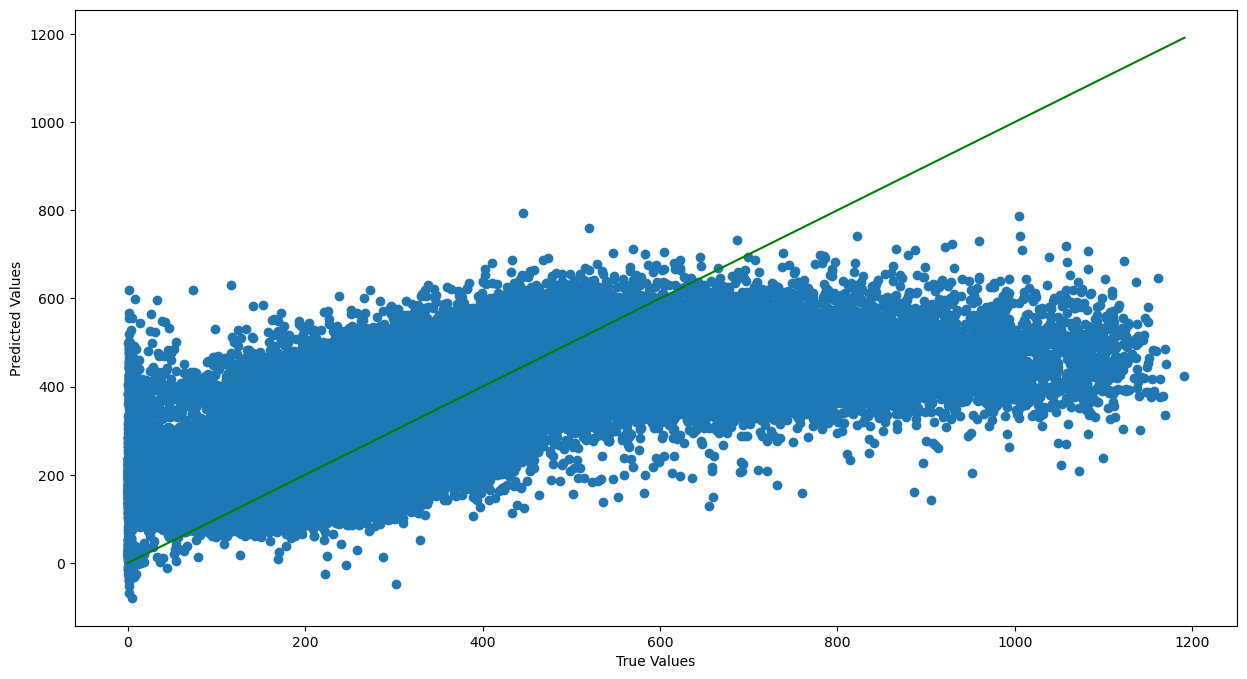

In [ ]:
# Heteroskedasticity plot


plt.figure(figsize=(15,8))
plt.scatter(y2_test, y2_pred_test_rdgcv)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], color='green')


plt.show()

#### **5.3.2.2. Feature Importance by SHAP Analysis**

In [ ]:
# SHAP Analysis, instantiate the Explainer

explainer = shap.Explainer(rdg_cv, X2_train_transformed_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


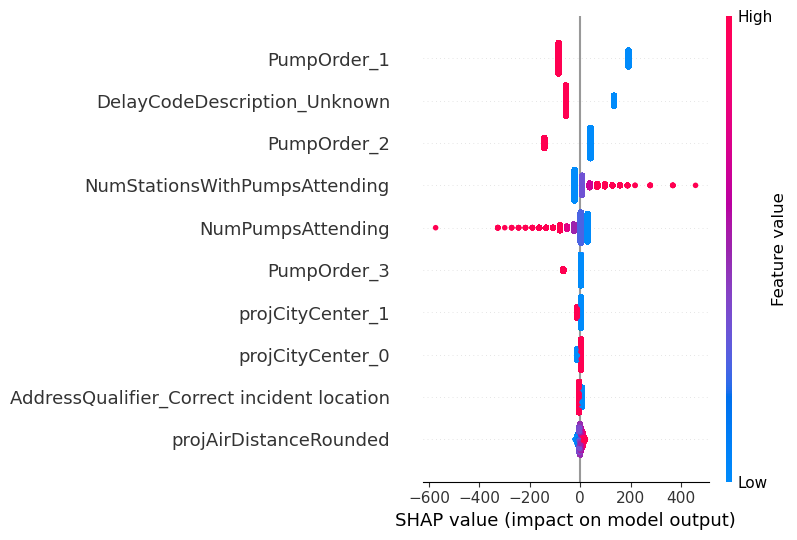

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- encoded features

shap_values = explainer.shap_values(X2_test_transformed_df)

shap.summary_plot(shap_values, X2_test_transformed_df, max_display=10, color_bar=True)

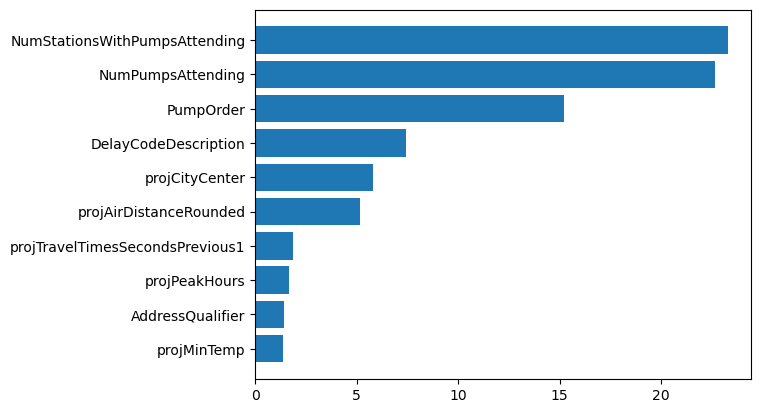

In [ ]:
# check the average impact (absolute mean shap values) of features across target classes -- original features (before encoding)
# for original categorical features, we use the mean shap value of the underlying encoded features to avoid giving too much weights to categorical features which have a lot of categories


shap_values_df = pd.DataFrame(np.abs(shap_values), columns=all_feature_names)

feature_importance_shap = np.mean(shap_values_df, axis=0)

feature_importance_shap_df = pd.DataFrame({'feature': feature_importance_shap.index, 'importance': feature_importance_shap.values})


normalized_importance_shap = []

for cat_feature in cat_var:
    mask = feature_importance_shap_df['feature'].str.startswith(cat_feature + '_')
    mean_abs_importance = np.mean(feature_importance_shap_df.loc[mask, 'importance'])
    normalized_importance_shap.append({'feature': cat_feature, 'importance': mean_abs_importance})

for num_feature in numeric_feature_names:
    importance = feature_importance_shap_df[feature_importance_shap_df['feature'] == num_feature]['importance'].values[0]
    normalized_importance_shap.append({'feature': num_feature, 'importance': importance})

importance_df_shap = pd.DataFrame(normalized_importance_shap)
importance_df_shap = importance_df_shap.sort_values(by='importance', ascending=False)

importance_df_shap.head(10)

plt.barh(importance_df_shap.head(10)[::-1].feature, importance_df_shap.head(10)[::-1].importance)
plt.show()

In [ ]:
df.DelayCodeDescription.unique()

array(['Unknown', 'Not held up', 'Traffic, roadworks, etc',
       'Traffic calming measures', 'Address incomplete/wrong',
       'On outside duty when mobilised',
       'Arrived but held up - Other reason', 'Appliance/Equipment defect',
       'Weather conditions', 'Mob/Radio problems when mobilised',
       'At drills when mobilised'], dtype=object)